# **Introduction**

Having a revenue-generating website is both an art and a science. Users are more and more demanding while their attention spans are shorter and shorter.

Every aspect of the web site gets designed to combat this trend. Analytics departments gather all the possible data to try finding bottlenecks. Design teams spend countless hours polishing the page and trying to make it as user-friendly as possible. In the end, they all have 15 seconds to impress the user and gain his interest before he leaves the page.

In this notebook, I am going to try to predict if the user will buy something from the website or not. The prediction is a simple classification problem with almost all possible website metrics given. The question is why to do it on a full dataset when you need to gather all the data again to replicate it in real life. 

I believe that this problem can use a new standpoint and that predicting is not the end goal here.  The machine learning algorithm and the way it ranks the importance of individual features is just as important as the final prediction. Finishing the best possible model and taking into account its feature importance ranking can help us determine what features should be the focus of the company when making alterations to the website. 

With this in mind, the goals of this notebook are:

* Perform a quick data clean
* Construct a Bayesian Hyperparameter Optimization function
* Train and test the best possible LightGBM model
* Analyze the feature importance graph

# **Importing libraries and data**

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix

import lightgbm as lgb

from hyperopt import hp, tpe
from hyperopt.fmin import fmin

import gc

In [4]:
df = pd.read_csv(r"../input/online-shoppers-intention/online_shoppers_intention.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12316 non-null  float64
 1   Administrative_Duration  12316 non-null  float64
 2   Informational            12316 non-null  float64
 3   Informational_Duration   12316 non-null  float64
 4   ProductRelated           12316 non-null  float64
 5   ProductRelated_Duration  12316 non-null  float64
 6   BounceRates              12316 non-null  float64
 7   ExitRates                12316 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

# **Data preparation**

In [6]:
def missing_KNN_imputer (df, n_neig, metric):
    
    """ This function replaces all missing numeric data using the KNN imputer"""
    
    #Define imputer
    imputer = KNNImputer(n_neighbors=n_neig, metric=metric)

    #Find columns with NaN and apply Imputer
    df.loc[:, df.isnull().any()] = imputer.fit_transform(df.loc[:, df.isnull().any()])

    #Return dataframe
    return df

In [7]:
def cat_encoding (column):

    """ This function takes a column and encodes the categorical variables with a unique key"""
    
    #List of unique values
    value_list = df[column].unique()

    #Creates a dict for encoding
    e_list = {}

    #Loop over all values in column and replace them with a number
    for count, value in enumerate(value_list):
        	e_list.update({value:count})
    df[column] = df[column].replace(e_list)
    
    #Returns altered column
    return df[column]


In [8]:
def replace_negative (column_list):
    
    """ This function replaces the negative values in some columns with a zero"""
    
    #Loops over columns in column list and replaces -1 with 0
    for column in column_list:

        df[column] = df[column].replace(-1,0)

    return df

Time to apply the functions to the designated columns.

In [9]:
column_list = ["Administrative_Duration","Informational_Duration","ProductRelated_Duration"]
df = replace_negative(column_list)

df["Month"] = cat_encoding("Month")
df["VisitorType"] = cat_encoding("VisitorType")

df = missing_KNN_imputer(df, 10, "nan_euclidean")

gc.collect()

del column_list

I am going to do a classical train/test split (80/20) for the model. 

In [10]:
#Def X and y
y = df["Revenue"]
X = df.drop("Revenue",axis=1)

gc.collect()

del df

In [11]:
#Train and test splits
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=22)
kf = StratifiedKFold(n_splits=5,random_state=33)

del X,y

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


# **Bayesian Hyperparameter Optimization**

Hyperparameter optimization is generally one of the more time-consuming and costly tasks. The Bayesian method alleviates some those issues in comparison to other available strategies. It focuses is more on the selection process of the hyperparameters that might yield improvement to the model rather than brute-forcing or random selection. The general idea behind it is that the algorithm proposes a set of hyperparameter candidates and evaluates them using the actual objective function. Those results are stored along with their respective candidates and used to construct/improve a probability model of the objective function. Repeating the evaluation process improves the probability function with every iteration and subsequently uses the probability function to select the hyperparameters with the greatest "Expected improvement".

The algorithm spends some more time with the selection process of the next hyperparameter to maximize the "Expected improvement" compared to the alternatives. However, it is still much cheaper in computational cost by spending less time evaluating poor hyperparameter choices.

In [12]:
#Hyperopt Bayesian Optimization
def objective(params):
    
    """"""

    params = {'learning_rate': params['learning_rate'],
     'max_depth': int(params['max_depth']),
     'subsample': params['subsample'],
     'num_leaves': int(params['num_leaves'])}

    model = lgb.LGBMClassifier(**params,random_state=19)

    score = cross_val_score(model, X_train, y_train, scoring="accuracy", cv=StratifiedKFold()).mean()

    print("Accuracy {:.3f} params {}".format(score, params))

    return score

space = {
    "learning_rate" : hp.choice("learning_rate", np.arange(0.05,0.31,0.05)),
    "max_depth" : hp.choice("max_depth", np.arange(5,80,1,dtype=int)),
    "subsample" : hp.uniform("subsample",0.8,1),
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    }

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

Accuracy 0.905 params {'learning_rate': 0.05, 'max_depth': 41, 'subsample': 0.9727450746980575, 'num_leaves': 18}
Accuracy 0.897 params {'learning_rate': 0.2, 'max_depth': 78, 'subsample': 0.800556918957787, 'num_leaves': 86}
Accuracy 0.901 params {'learning_rate': 0.1, 'max_depth': 31, 'subsample': 0.8452616367661148, 'num_leaves': 108}
Accuracy 0.904 params {'learning_rate': 0.1, 'max_depth': 54, 'subsample': 0.9926043899586827, 'num_leaves': 10}
Accuracy 0.902 params {'learning_rate': 0.05, 'max_depth': 39, 'subsample': 0.8280811486811667, 'num_leaves': 50}
Accuracy 0.898 params {'learning_rate': 0.2, 'max_depth': 54, 'subsample': 0.8864236434294712, 'num_leaves': 96}
Accuracy 0.897 params {'learning_rate': 0.25, 'max_depth': 15, 'subsample': 0.9095828374224644, 'num_leaves': 42}
Accuracy 0.900 params {'learning_rate': 0.1, 'max_depth': 46, 'subsample': 0.8360380682413665, 'num_leaves': 118}
Accuracy 0.901 params {'learning_rate': 0.05, 'max_depth': 69, 'subsample': 0.94468835242451

In [13]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'learning_rate': 5, 'max_depth': 71, 'num_leaves': 40.0, 'subsample': 0.8508119422422868}


# **LightGBM**

The classification problem was tackled with LightGBM, a tree-based machine-learning algorithm that dominated multiple Kaggle competitions. It is generally a great choice due to its many benefits regarding the speed and accuracy of predictions. Also, its GOSS and EFB inner workings allow me to play around with data on a decade-old laptop.

In [14]:
def lightgbm_model(X_train,y_train,X_test,cat_features,parms):

    test_pred = np.zeros(len(X_test))

    for train_index, test_index in kf.split(X_train,y_train):
        X_cv_train, X_cv_test = X_train.iloc[train_index], X_train.iloc[test_index]
        y_cv_train, y_cv_test = y_train.iloc[train_index], y_train.iloc[test_index]

        lgb_train = lgb.Dataset(X_cv_train,label = y_cv_train)
        lgb_test = lgb.Dataset(X_cv_test,label = y_cv_test)

        model = lgb.train(parms,train_set=lgb_train,num_boost_round=500,categorical_feature=cat_features,       valid_sets=lgb_test,verbose_eval=20, early_stopping_rounds=200)

        test_pred += model.predict(X_test,num_iteration=model.best_iteration)/5

    return test_pred, model

In [15]:
cat_features = ["SpecialDay",'Month','OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType','Weekend']

parms = {"objective" : "binary",
        'learning_rate': 0.04,
        'max_depth': 56, 
        'num_leaves': 50, 
        'subsample': 0.95}

test_pred, best_model = lightgbm_model(X_train,y_train,X_test,cat_features,parms)

gc.collect()

del cat_features, parms

Training until validation scores don't improve for 200 rounds
[20]	valid_0's binary_logloss: 0.275636


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Browser', 'Month', 'OperatingSystems', 'Region', 'SpecialDay', 'TrafficType', 'VisitorType', 'Weekend']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[40]	valid_0's binary_logloss: 0.237146
[60]	valid_0's binary_logloss: 0.225745
[80]	valid_0's binary_logloss: 0.222163
[100]	valid_0's binary_logloss: 0.219627
[120]	valid_0's binary_logloss: 0.218929
[140]	valid_0's binary_logloss: 0.220038
[160]	valid_0's binary_logloss: 0.219781
[180]	valid_0's binary_logloss: 0.220906
[200]	valid_0's binary_logloss: 0.222453
[220]	valid_0's binary_logloss: 0.224134
[240]	valid_0's binary_logloss: 0.225603
[260]	valid_0's binary_logloss: 0.2275
[280]	valid_0's binary_logloss: 0.228439
[300]	valid_0's binary_logloss: 0.230879
Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.218755
Training until validation scores don't improve for 200 rounds
[20]	valid_0's binary_logloss: 0.279219
[40]	valid_0's binary_logloss: 0.242276
[60]	valid_0's binary_logloss: 0.228312
[80]	valid_0's binary_logloss: 0.223823
[100]	valid_0's binary_logloss: 0.222658
[120]	valid_0's binary_logloss: 0.222634
[140]	valid_0's binary_logloss: 0.223429
[160]	vali

# **Scores**

We are going to evaluate the model using the accuracy score, f1 score and a confusion matrix.The scores should give us a pretty good idea on the general quality of the prediction.

In [29]:
print("The accuracy score for this model is {}".format(accuracy_score(y_test,test_pred.round())))
print("The f1 score for this model is {}".format(f1_score(y_test,test_pred.round())))

The accuracy score for this model is 0.902676399026764
The f1 score for this model is 0.6581196581196581


In [18]:
conf = confusion_matrix(y_test,test_pred.round())
print(conf)

gc.collect()

[[1995   90]
 [ 150  231]]


60

# **Feature importance and analysis**

Please keep two things in mind while looking at the plot. The first one being that the F score is the number of times the feature is used in the splitting process. The second and most important one is that this is how the machine learning model ranks the features. To put it more clearly, the model might miss some conclusions that a human can make from the data. That doesn't mean that the model is bad, but that it has a different perspective and that is what we are after.

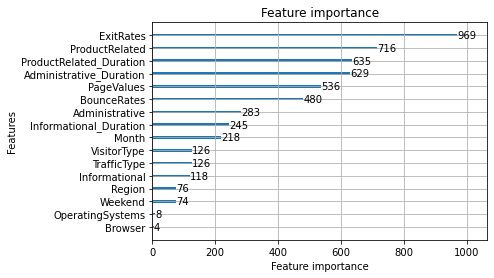

In [23]:
lgb.plot_importance(best_model)

Some of the features expectedly have a high ranking like exit rates, product-related pages, bounce rates etc. Nonetheless, a good amount of importance goes to "secondary factors" that are not immediately obvious. Those include the administrative part of the website, the categorical weekend function, region, month and informational duration. 

We cannot make a definitive conclusion about these factors as we lack information. However, we can point the company in the right direction that could yield more improvements.

# **Conclusion**

Another fun little classification project and I am pretty content with the results. Originally I wanted to create just a Bayesian optimization notebook. However, after playing around the data a bit I decided to expand it a little.

Thank you for your time & I hope you enjoyed it as much as I enjoyed making it.